In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import pandas as pd
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
import numpy as np

# Pandas私房手册-处理缺失值

## 缺失值的定义

### 什么是缺失值

对于不同类型的数据，比如浮点数、整数、布尔值和普通对象都会有缺少，或者不可用，或者`NA`（不是一个数字）的情况，这些情况下，我们也希望用一个值来表示，比如，`Python`就用`None`来表示，`pandas`使用`NaN`来表示这个“值”，统一称为缺失值，默认`NaN`为`float`类型。说这些的意思是，“缺失值”其实是人为定义的，比如我们可以在`pandas`中设置无穷大或者负无穷大也为缺失值：
```Python
pandas.options.mode.use_inf_as_na = True
```

### `None`和缺失值的不同 

在`python`中，`None`可以用于等值比较，但是`nan`不能，在`pandas`和`numpy`中，是把`None`当作`nan`的：

In [8]:
None == None
np.nan == np.nan

True

False

所以，只能使用`isna`或者`notna`来进行判断，而不能直接使用等值比较，那样不会得到你想要的结果：

In [11]:
df2['one'] == np.nan

a    False
b    False
c    False
d    False
e    False
f    False
g    False
h    False
Name: one, dtype: bool

### 整数类型的缺失值

因为`NaN`其实是一个浮点数，所以一列哪怕缺少一个值，那么整列都会被转换为`float dtype`。`panda`提供一个可为空的整数数组，可以通过显式设置`dtype`来使用该数组:

In [19]:
Series([1, 2, np.nan, 4])
Series([1, 2, np.nan, 4], dtype=pd.Int64Dtype())

0    1.0
1    2.0
2    NaN
3    4.0
dtype: float64

0      1
1      2
2    NaN
3      4
dtype: Int64

你也可以使用它的别名，注意`I`是大写，以表示和`numpy`的`int64`的区别：

In [18]:
Series([1, 2, np.nan, 4], dtype='Int64')

0      1
1      2
2    NaN
3      4
dtype: Int64

### 时间日期类型的缺失值

对于`datetime64[ns]`类型，`NaT`表示缺失的值。`panda`对象提供了`NaT`和`NaN`之间的兼容性。

In [26]:
df = pd.DataFrame(
    np.random.randn(5, 3),
    index=['a', 'c', 'e', 'f', 'h'],
    columns=['one', 'two', 'three'])
df['four'] = 'bar'
df['five'] = df['one'] > 0
df2 = df.copy()
df2['timestamp'] = pd.Timestamp('20120101')
df2.loc[['a', 'c', 'h'], ['one', 'timestamp']] = np.nan
df2
df2.dtypes.value_counts()

,one,two,three,four,five,timestamp
a,NaN,2.111696,1.204902,bar,True,NaT
c,NaN,0.071184,1.664767,bar,False,NaT
e,-1.149540,-0.311669,0.465258,bar,False,2012-01-01
f,0.612748,0.563905,-1.225974,bar,True,2012-01-01
h,NaN,0.935761,1.905329,bar,False,NaT


float64           3
datetime64[ns]    1
bool              1
object            1
dtype: int64

## 缺失值的各种操作

### 检测缺失值

可以使用`dataframe`或者`Series`实例的`isna()`和`notna()`方法来判断是否为缺失值：

In [27]:
df2 = df.reindex(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
df2['one']
df2['one'].isna()

a    1.317927
b         NaN
c   -0.327630
d         NaN
e   -1.149540
f    0.612748
g         NaN
h   -0.049730
Name: one, dtype: float64

a    False
b     True
c    False
d     True
e    False
f    False
g     True
h    False
Name: one, dtype: bool

不仅`Series`和`DataFrame`实例有`isna()`和`notna`方法，`pd`也有`isna()`和`notna()`的顶层函数：

In [28]:
pd.notna(df2)

,one,two,three,four,five
a,True,True,True,True,True
b,False,False,False,False,False
c,True,True,True,True,True
d,False,False,False,False,False
e,True,True,True,True,True
f,True,True,True,True,True
g,False,False,False,False,False
h,True,True,True,True,True


### 插入缺失值

你可以直接往序列里面插入缺失值，`pandas`会根据序列的`dtype`进行灵活的处理，赋予对应的“缺失值”，如下，序列是数值类型，`None`会被转换为`NaN`类型，同时因为`NaN`是浮点类型，整个数列会向上转换为`float`类型：

In [29]:
s = Series([1, 2, 3])
s[0] = np.nan
s

0    NaN
1    2.0
2    3.0
dtype: float64

如果`dtype`是`object`类型（`python`原生类型），那么`None`会保持原样：

In [30]:
s = Series(['a', 'b', 'c'])
s[0] = None
s[1] = np.nan
s

0    None
1     NaN
2       c
dtype: object

### 缺失值参与计算

缺失值的计算要牢记以下几点：
- 当对序列求和时，缺失值会被当作0处理。
- 如果序列全部都是缺失值，结果为0.
- 累积方法(如`cumsum()`和`cumprod()`)默认情况下忽略`NA`值，但将它们保存在结果数组中。若要覆盖此行为并包含`NA`值，可以使用`skipna=False`。

In [31]:
df = DataFrame([np.nan, np.nan, 1, 1, 1], columns=['A'])
df
df.sum()
df.cumsum()
df.cumsum(skipna=False)

,A
0,NaN
1,NaN
2,1.0
3,1.0
4,1.0


A    3.0
dtype: float64

,A
0,NaN
1,NaN
2,1.0
3,2.0
4,3.0


,A
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


### 缺失值/空值的和/积

0.22版本以后，空或者全部都是缺失值的序列和为0，积为1，和`numpy`保持一直，但是0.19版本之前，返回`NAN`:

In [32]:
Series([np.nan]).sum()
Series([]).sum()
Series([np.nan]).prod()
Series([]).prod()

0.0

0.0

1.0

1.0

注意，序列里面有多个缺失值（`np.nan`和`None`），“和”和“积”仍然是0，1，但是有多个空值就可能不一样了，比如空列表，和仍然为空，积会报错：

In [33]:
Series([np.nan, np.nan]).sum()
Series([np.nan, np.nan]).prod()
Series([[], []]).sum()
try:
    Series([[], []]).prod()
except Exception as e:
    print(e)

0.0

1.0

[]

can't multiply sequence by non-int of type 'list'


### 聚合中的缺失值

聚合中的缺失值会自动的排除，这种行为和`R`是一致的：

In [3]:
df = pd.DataFrame(
    np.random.randn(5, 3),
    index=['a', 'c', 'e', 'f', 'h'],
    columns=['one', 'two', 'three'])
df.loc[['a', 'c', 'h'], 'one'] = np.nan
df
df.groupby('one').mean()

,one,two,three
a,NaN,1.014290,-0.846967
c,NaN,-1.848715,-0.798101
e,1.554896,-1.386564,-0.662007
f,-0.596919,-0.014853,-0.204191
h,NaN,-0.897277,0.949424


,two,three
one,,
-0.596919,-0.014853,-0.204191
1.554896,-1.386564,-0.662007


### 填补缺失值

可以使用标量，规则，`Series`和字典对缺失值进行填充，标量很简单，这里主要对另外两种加以说明：

#### 按照规则填补 

按照规则的话主要有两种填补方式，`method`参数为`ffill`和`pad`表示按照序列的前一个进行填补，为`bfill`或者`backfill`表示按照序列的后一个进行填补，同时可以通过`axis`参数设置是按照行还是列的前一个进行填补。

In [4]:
df
df.fillna(method='bfill', axis=1)

,one,two,three
a,NaN,1.014290,-0.846967
c,NaN,-1.848715,-0.798101
e,1.554896,-1.386564,-0.662007
f,-0.596919,-0.014853,-0.204191
h,NaN,-0.897277,0.949424


,one,two,three
a,1.014290,1.014290,-0.846967
c,-1.848715,-1.848715,-0.798101
e,1.554896,-1.386564,-0.662007
f,-0.596919,-0.014853,-0.204191
h,-0.897277,-0.897277,0.949424


#### 使用`Series`或字典填补

也可以使用`dict`或者`Series`进行填补，`dict`的键或者`Series`的标签索引必须和`dataframe`的列标签匹配，比如使用列的均值进行填补，注意，此时不能设置`axis`为1：

In [5]:
df = pd.DataFrame(
    np.random.randn(5, 3),
    index=['a', 'c', 'e', 'f', 'h'],
    columns=['one', 'two', 'three'])
df.loc[['a', 'c', 'f'], 'one'] = np.nan
df.loc[['c', 'f'], 'two'] = np.nan
df.loc[['e', 'h'], 'three'] = np.nan
df
df.fillna(df.mean())

,one,two,three
a,NaN,1.387589,-2.131728
c,NaN,NaN,1.476784
e,0.080734,0.275454,NaN
f,NaN,NaN,-2.228795
h,1.202331,-0.614183,NaN


,one,two,three
a,0.641532,1.387589,-2.131728
c,0.641532,0.349620,1.476784
e,0.080734,0.275454,-0.961246
f,0.641532,0.349620,-2.228795
h,1.202331,-0.614183,-0.961246


你也可以只填补部分列：

In [6]:
df.mean()['two':'three']

two      0.349620
three   -0.961246
dtype: float64

In [7]:
df.fillna(df.mean()['two':'three'])

,one,two,three
a,NaN,1.387589,-2.131728
c,NaN,0.349620,1.476784
e,0.080734,0.275454,-0.961246
f,NaN,0.349620,-2.228795
h,1.202331,-0.614183,-0.961246


字典使用方法和`series`是类似的：

In [49]:
df.fillna({'two': 1, 'three':2})

,one,two,three
a,NaN,0.120028,-0.233290
c,NaN,1.000000,0.754159
e,-0.510838,-0.144266,2.000000
f,NaN,1.000000,-1.824954
h,-0.431344,-1.173246,2.000000


##### 使用行的均值进行填充

如果要使用行的均值进行填充，不能使用`fillna`方法，但是可以使用`where`方法，注意，`where`第二个参数只能传入标量，`series`，`dataframe`或者可调用对象，不能是数组或者列表，同时标签也需要匹配：

In [9]:
df

,one,two,three
a,NaN,1.387589,-2.131728
c,NaN,NaN,1.476784
e,0.080734,0.275454,NaN
f,NaN,NaN,-2.228795
h,1.202331,-0.614183,NaN


In [64]:
df
df.where(df.notna(), df.mean(axis=1), axis=0)

,one,two,three
a,NaN,0.120028,-0.233290
c,NaN,NaN,0.754159
e,-0.510838,-0.144266,NaN
f,NaN,NaN,-1.824954
h,-0.431344,-1.173246,NaN


,one,two,three
a,-0.056631,0.120028,-0.233290
c,0.754159,0.754159,0.754159
e,-0.510838,-0.144266,-0.327552
f,-1.824954,-1.824954,-1.824954
h,-0.431344,-1.173246,-0.802295


#### 使用`Interpolation`插值

##### 基本的线性插值

一种特殊的填补的方法是`Interpolation`，插值，根据缺失值前后的数据按照一定规则进行填补，默认采取的是线性插值：

19


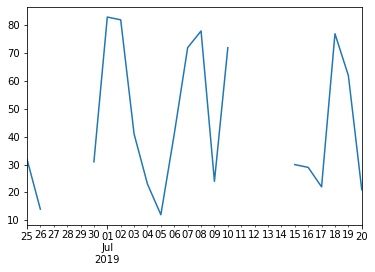

In [12]:
ts = pd.date_range("2019-6-25", "2019-7-20")
s = Series(np.random.randint(1, 100, 26), index=ts)
s["2019-6-27":"2019-6-29"] = None
s["2019-7-11":"2019-7-14"] = None
print(s.count())
s.plot();

使用`interpolate`插值以后：

26


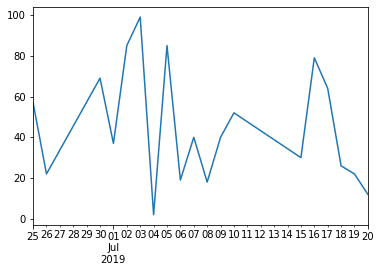

In [25]:
print(s.interpolate().count())
s.interpolate().plot();

##### `method`参数

插值可以根据索引进行智能推断，如果索引是时间的序列，`method`设置为`time`：

In [31]:
ts = Series([0, np.nan, 10, np.nan, 30], index=pd.DatetimeIndex(["2000-1-31", "2000-2-29", "2002-7-31", "2005-01-31", "2008-04-30"]))
ts
ts.interpolate()
ts.interpolate(method='time')

2000-01-31     0.0
2000-02-29     NaN
2002-07-31    10.0
2005-01-31     NaN
2008-04-30    30.0
dtype: float64

2000-01-31     0.0
2000-02-29     5.0
2002-07-31    10.0
2005-01-31    20.0
2008-04-30    30.0
dtype: float64

2000-01-31     0.000000
2000-02-29     0.317982
2002-07-31    10.000000
2005-01-31    18.714286
2008-04-30    30.000000
dtype: float64

如果索引是数值类型的话，`method`设置为`values`：

In [34]:
ser = Series([0, np.nan, 10], index=[0, 1, 10])
ser
ser.interpolate()
ser.interpolate(method='values')

0      0.0
1      NaN
10    10.0
dtype: float64

0      0.0
1      5.0
10    10.0
dtype: float64

0      0.0
1      1.0
10    10.0
dtype: float64

`method`参数还允许更高级的插值方法。如果安装了`scipy`，那么你可以将`scipy`里的各种统计方法传给`method`（参考完整的[`scipy`插补文档](docs.scipy.org/doc/scipy/reference/interpolate.html#univariate-interpolation)和[参考指南](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)），比如：
- 一个以增长率增长的时间序列，`method='barycentric'`可能比较好。
- 序列近似于一个累积分布函数，那么`method='pchip'`应该可以很好地工作。
- 要用平滑绘图的目标来填充缺失的值，可以考虑`method='akima'`。

如果这些方法需要传入参数，可以使用关键字参数进行传参。

##### `limit`，`limit_direction`和`limit_area`参数

默认插值是以有效数据为起点，从前往后进行插值，`limit`可以限制填补几个值，`limit_direction`设置方向，是从前往后，还是从后往前，还是`both`，0.23版本以后新增的`limit_area`比较难理解一点，它可以设置为`outside`或者`inside`，一般2个有效数据中间的区域被称为`inside`，只有一边是有效数据的区域被称为`outside`：

In [19]:
ser = Series([np.nan, np.nan, 5, 7, np.nan, np.nan, 13, np.nan, np.nan])
ser
ser.interpolate(limit_area='outside', limit_direction='both', limit=1)

0     NaN
1     NaN
2     5.0
3     7.0
4     NaN
5     NaN
6    13.0
7     NaN
8     NaN
dtype: float64

0     NaN
1     5.0
2     5.0
3     7.0
4     NaN
5     NaN
6    13.0
7    13.0
8     NaN
dtype: float64

### 丢弃包含缺失值的行或者列

`Series`和`dataframe`实例都有`dropna()`方法，可以通过`axis`参数来设置删除行还是列。容易出错的是，`axis=0`是删除行，`axis=1`是删除列。可以这样记忆，0是垂直方向，1是水平方向，假如是0，则沿着垂直方向一行一行检查是否包含`na`。

In [6]:
df = pd.DataFrame(
    np.random.randn(5, 3),
    index=['a', 'c', 'e', 'f', 'h'],
    columns=['one', 'two', 'three'])
df.loc[['a', 'c', 'f'], 'one'] = np.nan
df.loc[['c', 'f'], 'two'] = np.nan
df
df.dropna(axis=0)

,one,two,three
a,NaN,-0.805023,0.459417
c,NaN,NaN,-0.013441
e,-0.006400,-1.176783,0.454727
f,NaN,NaN,-1.009945
h,-0.349118,-1.446041,-1.000236


,one,two,three
e,-0.006400,-1.176783,0.454727
h,-0.349118,-1.446041,-1.000236


`how`，`thresh`参数都比较好理解，`how`可以设置为`all`或者`any`，表示行或列全部是`NaN`还是只要有`NaN`就丢弃，`thread`表示有几个`NaN`才丢弃，有一个`subset`用的可能较少，它是指定检查哪些行或者列的缺失值：

In [20]:
df
df.dropna(subset=['a', 'f'], axis=1)  # axis为1，丢弃a和h行包含缺失值的列

,one,two,three
a,NaN,1.387589,-2.131728
c,NaN,NaN,1.476784
e,0.080734,0.275454,NaN
f,NaN,NaN,-2.228795
h,1.202331,-0.614183,NaN


,three
a,-2.131728
c,1.476784
e,NaN
f,-2.228795
h,NaN


## 缺失值的转换规则和索引

虽然`pandas`支持存储整数和布尔类型的数组，但这些类型不能存储缺失值。当整数和布尔类型的数组引入缺失值时，比如进行重索引操作的时候，数据类型会发生转换，以下是转换的规则：
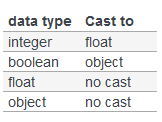

In [6]:
s = pd.Series(np.random.randn(5), index=[0, 2, 4, 6, 7])
s > 0
# 可见，bool类型已经转换成了object类型
crit = (s > 0).reindex(list(range(8)))
crit

0     True
2     True
4     True
6    False
7     True
dtype: bool

0     True
1      NaN
2     True
3      NaN
4     True
5      NaN
6    False
7     True
dtype: object